In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

#### 1. Create a straight line dataset using the linear regression formula (weight * X + bias).

- Set weight=0.3 and bias=0.9 there should be at least 100 datapoints total.
- Split the data into 80% training, 20% testing.
- Plot the training and testing data so it becomes visual.

In [2]:
weight = 0.3
bias = 0.9

datapoints = 1000000

# Generating random X values using a uniform distribution
# between 0 and 1 for X
X = torch.linspace(0, 100, datapoints)
y = weight * X + bias
# Data for X and y is now set.

split = int(0.9*len(X)) # 90% split

X_train, y_train = X[:split], y[:split] # 90% for training
X_test, y_test = X[split:], y[split:] # 10% for testing

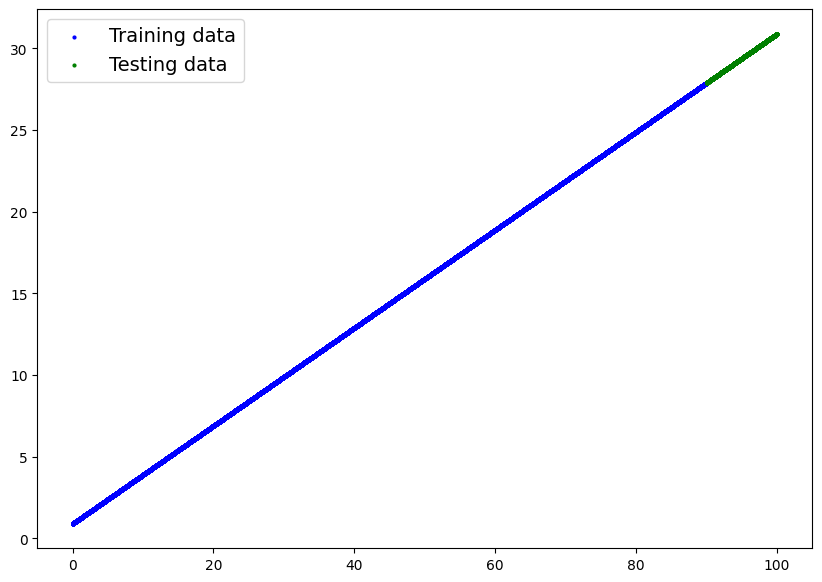

In [3]:
# plotting

def plot_predictions(train_data=X_train, 
                     train_labels=y_train, 
                     test_data=X_test, 
                     test_labels=y_test, 
                     predictions=None):
  """
  Plots training data, test data and compares predictions.
  """
  plt.figure(figsize=(10, 7))

  # Plot training data in blue
  plt.scatter(train_data, train_labels, c="b", s=4, label="Training data")
  
  # Plot test data in green
  plt.scatter(test_data, test_labels, c="g", s=4, label="Testing data")

  if predictions is not None:
    # Plot the predictions in red (predictions were made on the test data)
    plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")

  # Show the legend
  plt.legend(prop={"size": 14});

plot_predictions()

---

#### 2. Build a PyTorch model by subclassing nn.Module.

- Inside should be a randomly initialized nn.Parameter() with requires_grad=True, one for weights and one for bias.
- Implement the forward() method to compute the linear regression function you used to create the dataset in 1.
- Once you've constructed the model, make an instance of it and check its state_dict().


In [4]:
# way 1

if torch.backends.mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"

class SimpleLinearRegressionV1(nn.Module):
    def __init__(self):
        super().__init__()

        self.weights = nn.Parameter(
            torch.randn(1, dtype=torch.float32),
            requires_grad=True
            )

        self.biases = nn.Parameter(
            torch.randn(1, dtype=torch.float32),
            requires_grad=True
            )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.weights * x + self.biases

In [5]:
torch.manual_seed(741)

model_01 = SimpleLinearRegressionV1()
model_01.state_dict()

OrderedDict([('weights', tensor([0.3076])), ('biases', tensor([0.2766]))])

In [16]:
# way 2

class SimpleLinearRegressionV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(
            in_features=1,
            out_features=1,
            bias=True
        )
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [18]:
torch.manual_seed(741)

model_02 = SimpleLinearRegressionV2()
model_02.state_dict()

OrderedDict([('linear_layer.weight', tensor([[-0.2209]])),
             ('linear_layer.bias', tensor([-0.7778]))])

---

### A quick detour

Let me take a quick detour to explain to myself what the significance is behind using `1` for `in_features` and `out_features` in `nn.Linear`. What do these numbers represent? 

Of course, I could simply wrap it up by stating to myself that it's the number of features in the input and the number of features in the output. But, I wanted to go a little further. What if the number wasn't 1? What if it wasn't a single number? What if it was a matrix?

I tried with multiple inputs and outputs.

Below, I consider a concrete example with:
- 3 input features
- 2 output features

The weight matrix W would have shape (3, 2) because:
- It needs to map 3 inputs to 2 outputs
- Each column represents the weights for one output feature

The bias vector b would have shape (2) because:
- There needs to be one bias term for each output feature

In [21]:
X_ex = torch.randn(3,3)
X_ex, X_ex.shape

(tensor([[ 0.5320,  0.3494, -0.7011],
         [ 0.1923,  0.9713, -0.5344],
         [ 0.1000, -0.4966, -1.4584]]),
 torch.Size([3, 3]))

In [22]:
W_ex = torch.randn(3,2)
W_ex, W_ex.shape

(tensor([[-0.8615, -1.0990],
         [ 1.6957, -1.1614],
         [-0.2732,  0.6632]]),
 torch.Size([3, 2]))

In [23]:
b_ex = torch.randn(2)
b_ex, b_ex.shape

(tensor([ 0.0318, -0.6813]), torch.Size([2]))

So, computation for this is:
$$y[i, j] = x[i, 0] * W[0, j] + x[i, 1] * W[1, j] + b[j]$$



In [28]:
y_ex = X_ex @ W_ex + b_ex
y_ex

tensor([[ 0.3575, -2.1368],
        [ 1.6591, -2.3752],
        [-0.4979, -1.1816]])

A PyTorch model for this would be:

In [37]:
class MultiInputOutputModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(
            in_features=3, out_features=2, bias=True, dtype=torch.float32
            )
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)

In [38]:
# creating an instance of this model
multi_model = MultiInputOutputModel()
multi_model.state_dict()

OrderedDict([('linear.weight',
              tensor([[ 0.4647, -0.2825, -0.0710],
                      [ 0.4594,  0.3356,  0.3218]])),
             ('linear.bias', tensor([0.3368, 0.1603]))])

Here, I can see that the `linear.weight` has shape (2, 3) (despite our intuition that it should be (3, 2)) and the `linear.bias` has shape (2).

This is because PyTorch's `nn.Linear` class always transposes the weight matrix to (out_features, in_features). It calls the weight matrix `W` and the input matrix `X` and computes `X @ W.T + b`. "Affine transformation" is the term used for this operation.

This is a bit counterintuitive, but it's a consequence of how PyTorch handles matrix multiplication.

**In summary:**

Case 1:
- a `nn.Linear` layer with `in_features=3` and `out_features=2` will have a weight matrix of shape (2, 3).
- the input matrix `X` will be multiplied by the weight matrix `W.T` (transposed) and then added to the bias vector `b`. So, the bias vector `b` will have shape (2).

Case 2:
- a `nn.Linear` layer with `in_features=5` and `out_features=12` will have a weight matrix of shape (12, 5).
- the input matrix `X` will be multiplied by the weight matrix `W.T` (transposed) and then added to the bias vector `b`. So, the bias vector `b` will have shape (12).


Of course, I can also set the weights and biases manually. 

Here, I set the weights and biases manually for the `multi_model` instance.

In [35]:
# setting specific weights and biases for demo
with torch.inference_mode():
    multi_model.linear.weight = nn.Parameter(torch.tensor([[0.1, 0.2],
                                                     [0.3, 0.4],
                                                     [0.5, 0.6]]))
    multi_model.linear.bias = nn.Parameter(torch.tensor([0.01, 0.02]))


In [36]:
multi_model.state_dict()

OrderedDict([('linear.weight',
              tensor([[0.1000, 0.2000],
                      [0.3000, 0.4000],
                      [0.5000, 0.6000]])),
             ('linear.bias', tensor([0.0100, 0.0200]))])

Here, I can see that the `linear.weight` has shape (3, 2) and the `linear.bias` has shape (2).

```python
OrderedDict([('linear.weight',
              tensor([[0.1000, 0.2000],
                      [0.3000, 0.4000],
                      [0.5000, 0.6000]])),
             ('linear.bias', tensor([0.0100, 0.0200]))]
```

Obviously, we don't really (and often it is not) set the weights and biases manually. We use the `nn.Linear` class to do that because we probably don't even know what the weights and biases are. We let the model learn them.


#### Detour over

---

#### 3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.

- Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
- Write a training loop to perform the appropriate training steps for 300 epochs.
- The training loop should test the model on the test dataset every 20 epochs.
